# Plot emulator calls for a given model

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
# our own modules
import simplest_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import camb_cosmo
import fit_linP
import recons_cosmo
import compute_likelihood

### Specify suite of simulations to use, read P1D arxiv and setup simplest emulator

In [2]:
basedir='/Users/font/CosmoData/test_sim_emulator/test_medium/'
#basedir='../mini_sim_suite/'
p1d_label='mf_p1d'
skewers_label='Ns100_wM0.05'
emu=simplest_emulator.SimplestEmulator(basedir,p1d_label,skewers_label,verbose=True)

latin hyper-cube data {'param_space': {'Om_star': {'ip': 0, 'min_val': 0.955, 'max_val': 0.975, 'z_star': 3.0, 'latex': '$\\Omega_\\star$'}, 'Delta2_star': {'ip': 1, 'min_val': 0.25, 'max_val': 0.45, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\Delta^2_\\star$'}, 'n_star': {'ip': 2, 'min_val': -2.35, 'max_val': -2.25, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$n_\\star$'}, 'alpha_star': {'ip': 3, 'min_val': -0.265, 'max_val': -0.165, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\alpha_\\star$'}, 'mu_He': {'ip': 4, 'min_val': 0.5, 'max_val': 2.0, 'latex': '$\\mu_{\\rm He}$'}, 'mu_H': {'ip': 5, 'min_val': 0.5, 'max_val': 2.0, '   latex': '$\\mu_{\\rm H}$'}}, 'nsamples': 10, 'samples': {'0': [0.96, 0.32, -2.325, -0.22, 0.875, 1.7750000000000001], '1': [0.966, 0.4, -2.295, -0.23, 1.175, 0.575], '2': [0.968, 0.36, -2.285, -0.26, 1.7750000000000001, 1.625], '3': [0.97, 0.3, -2.315, -0.18, 1.3250000000000002, 1.3250000000000002], '4': [0.974, 0.34, -2.305, -0.21000000000000002, 1.475, 1.175], '5': [

### Read P1D data from Palanque-Delabrouille et al. (2013), to get redshift bins

In [3]:
basedir='../../p1d_data/data_files/PD2013/'
data=data_PD2013.P1D_PD2013(basedir=basedir,blind_data=True)
zs=data.z
Nz=len(zs)

### Setup nuisance models

In [4]:
mf_model=mean_flux_model.MeanFluxModel()
T_model=thermal_model.ThermalModel()

In [5]:
z=3.4
print('<F>(z=%.2f) = %f'%(z,mf_model.get_mean_flux(z)))
print('T_0(z=%.2f) = %f'%(z,T_model.get_T0(z)))
print('gamma(z=%.2f) = %f'%(z,T_model.get_gamma(z)))

<F>(z=3.40) = 0.542428
T_0(z=3.40) = 10000.000000
gamma(z=3.40) = 1.456532


### Setup cosmological model

In [6]:
# specify cosmology
cosmo = camb_cosmo.get_cosmology(mnu=0.15, ns=0.965, omch2=0.12)
# print relevant information about the cosmology object
camb_cosmo.print_info(cosmo)

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 1.6128E-03, T_CMB = 2.7255E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00


In [7]:
# compute linear power parameters, around z_star and kp_kms
z_star=3.0
kp_kms=0.009
linP_model=fit_linP.LinearPowerModel(cosmo,z_star=z_star,k_units='kms',kp=kp_kms)
linP_model.get_params()

{'Delta2_star': 0.34359089153174016,
 'alpha_star': -0.21586983258446132,
 'f_star': 0.97514327990258953,
 'g_star': 0.968209492732573,
 'n_star': -2.300572652881717}

### Use fiducial cosmology to reconstruct input cosmology

In [8]:
# setup fiducial cosmology
cosmo_fid = camb_cosmo.get_cosmology()
# reconstruct cosmology using linear parameter model (at z_star, kp_kms)
rec_cosmo=recons_cosmo.ReconstructedCosmology(linP_model,cosmo_fid)
# compute linear power parameters at each redshift (in Mpc)
linP_Mpc_params=rec_cosmo.get_linP_Mpc_params(zs)

Note: redshifts have been re-sorted (earliest first)


### For a given pair of parameters, plot arxiv and emulator calls

In [9]:
emu_calls=[]
for iz in range(Nz):
    # acess data for this redshift
    z=zs[iz]
    # get emulator parameters for linear power, at this redshift (in Mpc)
    call=linP_Mpc_params[iz]
    # get emulator parameters for nuisance models, at this redshift
    call['mF']=mf_model.get_mean_flux(z)
    call['gamma']=T_model.get_gamma(z)
    T0=T_model.get_T0(z)
    sigT_kms=thermal_model.thermal_broadening_kms(T0)
    dkms_dMpc=rec_cosmo.reconstruct_Hubble(z)/(1+z)
    call['sigT_Mpc']=sigT_kms/dkms_dMpc
    emu_calls.append(call)

In [10]:
def overplot_parameter_pair(emu,emu_calls,param_1,param_2,zs=None):
    # figure out values of param_1,param_2 called
    call_1=[emu_call[param_1] for emu_call in emu_calls]
    print(param_1,'was called at',call_1)
    call_2=[emu_call[param_2] for emu_call in emu_calls]
    print(param_2,'was called at',call_2)
    # figure out values of param_1,param_2 in arxiv
    emu_1=np.array([emu.arxiv.data[i][param_1] for i in range(len(emu.arxiv.data))])
    print(param_1,'first values in arxiv',emu_1[:5])
    emu_2=np.array([emu.arxiv.data[i][param_2] for i in range(len(emu.arxiv.data))])
    print(param_2,'first values in arxiv',emu_2[:5])
    # overplot
    if zs is not None:
        emu_z=np.array([emu.arxiv.data[i]['z'] for i in range(len(emu.arxiv.data))])
        zmin=min(emu_z)
        zmax=max(emu_z)
        plt.scatter(emu_1,emu_2,c=emu_z,s=1,vmin=zmin, vmax=zmax)
        plt.scatter(call_1,call_2,c=zs,s=50,vmin=zmin, vmax=zmax)
        cbar=plt.colorbar()
        cbar.set_label("Redshift", labelpad=+1)
    else:
        plt.scatter(emu_1,emu_2,s=5)
        plt.scatter(call_1,call_2,s=25)        
    plt.xlabel(param_1)
    plt.ylabel(param_2)

mF was called at [0.80075859414516326, 0.76380723990664612, 0.72386708455399551, 0.68128831772300569, 0.63650570143405727, 0.59002878758457866, 0.54242806197447857, 0.49431740593191842, 0.44633357154790776, 0.39911365088156847, 0.35327175198505489, 0.30937624518734685]
Delta2_p was called at [0.52940508668690001, 0.49084504946668728, 0.45603102701476073, 0.42463796726199332, 0.3963222761532938, 0.3707514234608501, 0.34761780307480111, 0.32664399893257223, 0.30758350505290799, 0.29021917083794507, 0.27436062941269912, 0.25984139094962927]
mF first values in arxiv [ 0.21217034  0.14163507  0.10148535  0.0762011   0.05918799]
Delta2_p first values in arxiv [ 0.12269372  0.12269372  0.12269372  0.12269372  0.12269372]


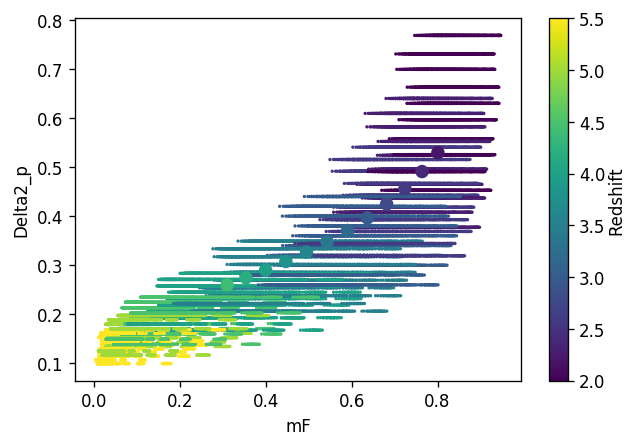

In [11]:
overplot_parameter_pair(emu,emu_calls,'mF','Delta2_p',zs)

f_p was called at [0.95899824656437238, 0.96442738525451488, 0.96877063491350479, 0.97227822727415136, 0.97514327324728511, 0.97749755431559493, 0.97944520219171294, 0.98107318967205248, 0.98244156956366979, 0.98359699813521018, 0.98457651207130714, 0.9854157902553724]
Delta2_p was called at [0.52940508668690001, 0.49084504946668728, 0.45603102701476073, 0.42463796726199332, 0.3963222761532938, 0.3707514234608501, 0.34761780307480111, 0.32664399893257223, 0.30758350505290799, 0.29021917083794507, 0.27436062941269912, 0.25984139094962927]
f_p first values in arxiv [ 0.9935774  0.9935774  0.9935774  0.9935774  0.9935774]
Delta2_p first values in arxiv [ 0.12269372  0.12269372  0.12269372  0.12269372  0.12269372]


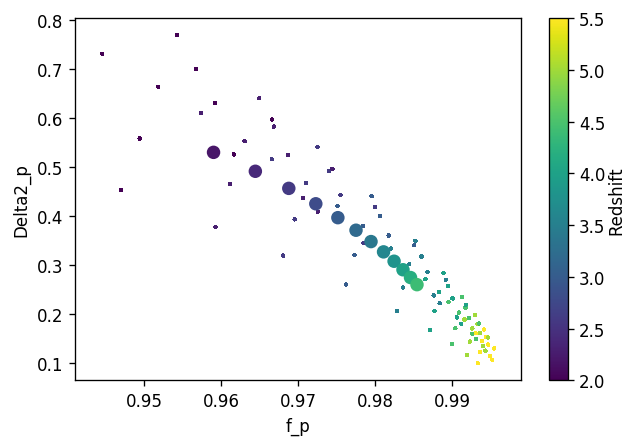

In [12]:
overplot_parameter_pair(emu,emu_calls,'f_p','Delta2_p',zs)

n_p was called at [-2.3007135087498813, -2.3007135087498813, -2.3007135087498813, -2.3007135087498813, -2.3007135087498813, -2.3007135087498813, -2.3007135087498805, -2.3007135087498813, -2.3007135087498805, -2.3007135087498805, -2.3007135087498822, -2.3007135087498813]
Delta2_p was called at [0.52940508668690001, 0.49084504946668728, 0.45603102701476073, 0.42463796726199332, 0.3963222761532938, 0.3707514234608501, 0.34761780307480111, 0.32664399893257223, 0.30758350505290799, 0.29021917083794507, 0.27436062941269912, 0.25984139094962927]
n_p first values in arxiv [-2.32500038 -2.32500038 -2.32500038 -2.32500038 -2.32500038]
Delta2_p first values in arxiv [ 0.12269372  0.12269372  0.12269372  0.12269372  0.12269372]


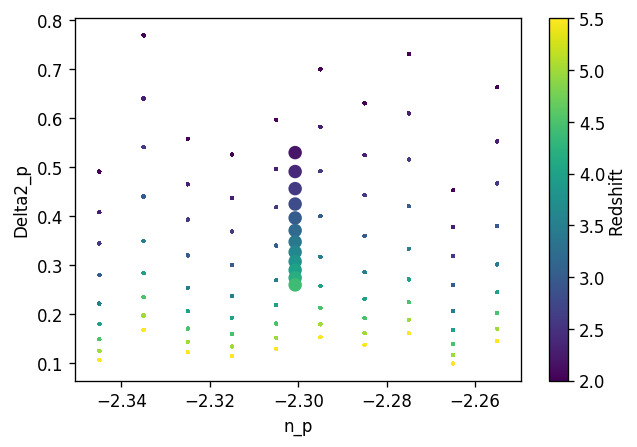

In [13]:
overplot_parameter_pair(emu,emu_calls,'n_p','Delta2_p',zs)

n_p was called at [-2.3007135087498813, -2.3007135087498813, -2.3007135087498813, -2.3007135087498813, -2.3007135087498813, -2.3007135087498813, -2.3007135087498805, -2.3007135087498813, -2.3007135087498805, -2.3007135087498805, -2.3007135087498822, -2.3007135087498813]
alpha_p was called at [-0.21576273788697528, -0.21576273788698067, -0.21576273788697409, -0.2157627378869619, -0.21576273788697364, -0.21576273788697739, -0.21576273788696995, -0.21576273788697467, -0.21576273788697653, -0.21576273788697711, -0.2157627378869697, -0.21576273788696404]
n_p first values in arxiv [-2.32500038 -2.32500038 -2.32500038 -2.32500038 -2.32500038]
alpha_p first values in arxiv [-0.22000105 -0.22000105 -0.22000105 -0.22000105 -0.22000105]


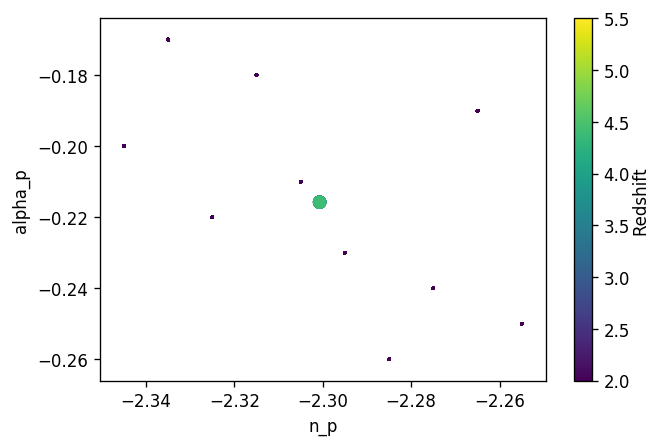

In [14]:
overplot_parameter_pair(emu,emu_calls,'n_p','alpha_p',zs)

gamma was called at [1.5523173420452847, 1.5336092579325602, 1.5161773512573462, 1.4998705770834098, 1.4845625705324339, 1.4701466103212635, 1.4565317960122977, 1.4436401056449923, 1.4314041022302444, 1.4197651254234163, 1.4086718507731002, 1.3980791308038094]
sigT_Mpc was called at [0.13071399425598651, 0.12746008021889133, 0.12437244717799824, 0.12145041127572205, 0.1186885644151414, 0.11607900001346579, 0.11361265770091636, 0.11128012641489779, 0.10907211376093627, 0.106979709622334, 0.10499452325771577, 0.10310874319194681]
gamma first values in arxiv [ 0.80537024  0.80537024  0.80537024  0.80537024  0.80537024]
sigT_Mpc first values in arxiv [ 0.07997658  0.07997658  0.07997658  0.07997658  0.07997658]


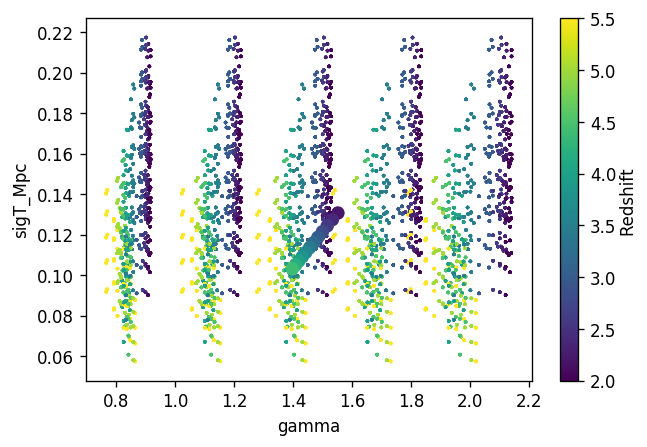

In [15]:
overplot_parameter_pair(emu,emu_calls,'gamma','sigT_Mpc',zs)